<a href="https://colab.research.google.com/github/Adam129511/sieci2/blob/main/CNN_catsVSdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##KONWOLUCYJNE SIECI NEURONOWE - Dogs vs Cats
Projekt polega na przyjrzeniu się sieciom konwolucyjnym i próbie zastosowania tych sieci w zagadnieniach klasyfikacji obrazu. Pokażemy jak postępować w przypadku niewielkiego zbioru danych treningowych i jakie techniki zastosować w celu optymalizacji takich modeli

W odróżnieniu od sieci gęstych, które uczą się cech globalnie, sieci konwolucyjne uczą się lokalnych wzorców. Innymi słowy wzorce rozpoznawane przez sieć konwolucyjną są niezależne od przesunięcia, co charakteryzuje sieci CNN bardzo dużą wydajnością.

Kolejną zaletą sieci CNN jest możliwość uczenia przestrzennej hierarchi wzorców. Pierwsze warstwy uczą się małych lokalnych wzorców, takich jak krawęzie, zaś kolejne warstwy będą uczyły się większych struktur składających się z elementów rozpoznanych przez początkowe warstwy.




#Czyszczenie katalogu roboczego


> Wpisując ba początku komórki polecenie %%bash jesteśmy w stanie wykonywać polecenia bashowe na systemie goszczącym naszą instancję notebook`a. Na początku wyczyścimy nasz katalog roboczy






In [ ]:
%%bash
rm -rf /content/*

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

#Pobieranie danych

Dane pobierzemy z bucketu S3. S3 jest to usługa storage w chmurze Amazona.

Nazwa bucketu to: ml-repository-krakers.
Spakowany plik dogs-vs-cats.zip ma nieco ponad 812 MB i jest przechowywany w regionie UE(ireland)

In [ ]:
%%bash
pwd #funkcja drukująca katalog roboczy w którym się znajdujemy
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip #funckcja pobiera dane i zapisuje w pliku cats_and_dogs.zip
ls


/content
cats_and_dogs.zip


#Wypakowanie danych

In [ ]:
%%bash
unzip cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train
unzip -q /content/test1.zip




Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: test1.zip               


In [ ]:
%%bash


ls


cats_and_dogs.zip
kaggle_original_data
test1
test1.zip


#Zdefiniowanie uzytecznych funkcji

In [ ]:
def make_accuracy_plot(history):
     #Funkcja zwraca wykres dokładośći (accuracy) modelu na zbiorze treningowym i walidacyjnym
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize = (10,8))
    plt.plot(epochs, acc, label = "dokładność trenowania", marker = 'o')
    plt.plot(epochs, val_acc, label = "dokładność walidacji", marker = 'o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('epoki')
    plt.ylabel('Dokładność')
    plt.show()

def make_loss_plot(history): #Funkcja zwraca wykres straty (loss) na zbiorze treningowym i walidacyjnym
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs= range(1, len(loss)+1)

    plt.figure(figsize = (10,8))
    plt.plot(epochs, loss, label = "Strata trenowania", marker = 'o')
    plt.plot(epochs, val_loss, label = "Strata walidacji", marker = 'o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('epoki')
    plt.ylabel('Strata')
    plt.show()

def display_augmented_images(directory, index):#Funkcja zwraca wykres przykładowych obrazów za pomocą techniki augmentacji danych.

    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)] #pobranie ściezek do plików gdzie są zdjęcia
    img_path = fnames[index]
    img = image.load_img(img_path, target_size=(150,150))

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 1
    plt.figure(figsize=(20,14))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(3,4,i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i+=1
        if i % 13 == 0:
            break



##Przygotowanie katalogów
Nasze dane będą znajdować się w katalogu:

> /content/cats_and_dogs

podzielimy ten katalog na trzy podkatalogi:
*   train
*   valid
*   test

W zbiorze treningowym odłożymy 2000 próbek(1000 zdjęciów psów i 1000 zdjęć kotów), do zbioru walidacyjnego trafi 1000 próbek (500 zdjęć psów i 500 zdjęć kotów), zaś do zbioru testowego ostatnie 1000 próbek (500 zdjęć psów i 500 zdjęć kotów).











In [ ]:
from IPython.testing import test
#ścieżka do oryginalnego zbioru
original_dataset_dir = '/content/kaggle_original_data'
#katalog w którym umieszczamy nasze dane
base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir): #tworzy katalog cats_and_dogs jeśli takiego nie ma

    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train') #katalog treningowy
valid_dir = os.path.join(base_dir, 'valid') #katalog zbioru walidacyjnego
test_dir = os.path.join(base_dir, 'test') #katalog zbioru testowego

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)


In [ ]:
#rozdzielamy zdjęcia kotów
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)


#rozdzielamy zdjęcia psów
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Sprawdzanie poprawności podziału


In [ ]:
print('Liczba kotów - zbiór treningowy', len(os.listdir(train_cats_dir)))
print('Liczba kotów - zbiór walidacyjny', len(os.listdir(valid_cats_dir)))
print('Liczba kotów - zbiór testowy', len(os.listdir(test_cats_dir)))

print('Liczba psów - zbiór treningowy', len(os.listdir(train_dogs_dir)))
print('Liczba psów - zbiór walidacyjny', len(os.listdir(valid_dogs_dir)))
print('Liczba psów - zbiór testowy', len(os.listdir(test_dogs_dir)))

Liczba kotów - zbiór treningowy 1000
Liczba kotów - zbiór walidacyjny 500
Liczba kotów - zbiór testowy 500
Liczba psów - zbiór treningowy 1000
Liczba psów - zbiór walidacyjny 500
Liczba psów - zbiór testowy 500


Przyjrzenie się przykładowym obrazkom - koty


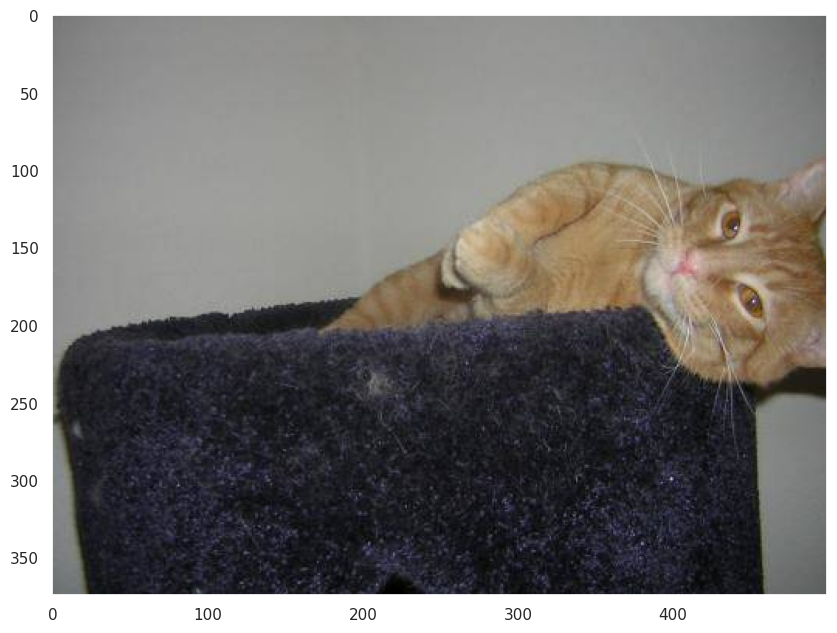

In [ ]:
from tensorflow.keras.preprocessing import image

index = 232
img_path = '/content/cats_and_dogs/train/cats/cat.' \
            +str(index) + '.jpg'

img = image.load_img(img_path)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.grid(False)

Przyjrzenie się przykładowym obrazkom - psy



In [ ]:
from tensorflow.keras.preprocessing import image

index = 232
img_path = '/content/cats_and_dogs/train/dogs/dog.' \
            +str(index) + '.jpg'

img = image.load_img(img_path)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.grid(False)

##Budowa modelu

Do budowy modelu wykorzystamy klasę Sequential biblioteki Keras. Pozwala ona dosyć wygodnie budować model niejako definiując kolejne warstwy tak, jakbyśmy układali je na stosie. Omówimy sobie krótko poszczególne warstwy.

Warstwa Conv2D jest warstwą konwolucji, w której należy podać minimum trzy parametry: liczbę filtrów,  dzięki którym będą wydobywane cechy, rozmiar jądra(wielkość okna konwolucji, zwyczajowo 3x3 lub 5x5) oraz funkcję aktywacji (najczęściej stosowana funkcja relu). Dodatkowo w pierwszej warstwie należy określić parametr input_shape, który przyjmuje rozmiar danych wejściowych. W naszym przypadku (150,150,3). Pierwsze dwie wartości określają szerokość i wysokość obrazka, trzeci natomiast głębie kolorów w tym przypadku 3.

Warstwa MaxPooling2D jest operacją skalowania. W dużym uproszczeniu polega na redukcji wymiarowości przechodząc po obrazie oknami ekstrakcji, które zwracają maksymalną zaobserwowaną wartość w danym oknie ( zwykle rozmiar okna 2x2, przy kroku przesunięcia równym 2) pomagając tym samym zmniejszyć rozmiar danych wejściowych do kolejnej warstwy o połowę, co znacząco przyśpiesza proces uczenia.

Warstwa Flatten wypłaszcza nam nasze dane w celu połączenia ich warstwami gęstymi pod koniec budowy modelu. Ostatnią funkcją aktywacji będzie funkcja sigmoid, która zwóri prawdopodobieństwo przynależności obrazka do poszczególnej klasy

In [ ]:

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = (28, 28, 1) ))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation = 'relu'))
model.add(Dense(units=10, activation='softmax'))

model.summary()